# Parse It to array

In [7]:
import numpy as np

In [19]:
from mido import MidiFile
# mid = MidiFile('../data/JSB Chorales/train/4.mid')
# mid = MidiFile('../data/bach-chorales-1-500/bach-1')
# mid = MidiFile('../data/bachcentral_midi/gold_aria.mid') # all files in that folder seems broken... only note ons
# mid = MidiFile('../data/bach-chorales-4501-5000/bach-4501')
# mid = MidiFile('../data/kunstderfuge_com_beethoven_sonatas_htm/') # not midi files?

OSError: MThd not found. Probably not a MIDI file

In [9]:
def compute_note_positions(mid, verbose=False):
    """
    Each message in a MIDI file has a delta time, which tells how many ticks have passed since the last message. 
    The length of a tick is defined in ticks per beat. 
    This value is stored as ticks_per_beat in MidiFile objects and remains fixed throughout the song.
    """    
    notes = []

    if verbose:
        print(len(mid.tracks))

    for i, track in enumerate(mid.tracks):
        current_tick = 0
        
        if verbose:
            print('Track {}: {}'.format(i, track.name))

        for msg in track:
            msg_data = msg.dict()
            event_type, time, note = msg_data['type'], msg_data['time'], msg_data.get('note', -1)
            current_tick += time
            
            if verbose:
                print("Event: {:10} Time: {:4}   AbsTime: {:6}  Note: {:3}".format(event_type, time, current_tick, note))

            if event_type.startswith('note'):
                notes.append((event_type, current_tick, note))
                
                
    # do we need to sort the notes if there are different channels?
    # notes = list(sorted(notes, key=lambda x: x[1]))
    return notes

In [10]:
def get_note_array(notes):
    """
    Given a list of midi notes (tuple of (event, current tick, note no.)),
    construct an array analogous to "piano roll representation"
    """
    max_tick = max([x[1] for x in notes]) + 1
    X = np.zeros((max_tick, 128))
    X_noteon  = np.zeros((max_tick, 128))
    X_noteoff = np.zeros((max_tick, 128))
    
    for event, tick, note in notes:
        
        if event == 'note_on':
            X[tick:, note] = 1
            X_noteon[tick, note] = 1

        if event == 'note_off':
            X[tick:, note] = 0
            X_noteoff[tick, note] = 1
            
    return X, X_noteon, X_noteoff

def note_array_to_midi(note_array):
    """
    Given a piano roll representation, reconstruct a midi file.
    """
    # TODO
    return

In [11]:
notes = compute_note_positions(mid, verbose=0)
all_ticks = np.array(list(sorted(set([x[1] for x in notes]))))
minimum_increment = min(all_ticks[1 :] - all_ticks[: -1])
X, X_noteon, X_noteoff = get_note_array(notes)

In [12]:
X.shape, minimum_increment

((65001, 128), 30)

In [13]:
def first_nonzero(x):
    for i, e in enumerate(x):
        if e!=0:
            return i

In [14]:
first_nonzero(X.max(axis=1))

3000

In [15]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
X.shape

(65001, 128)

In [17]:
lowest_note, highest_note = first_nonzero(X.max(axis=0)), 128-first_nonzero(X.max(axis=0)[::-1])

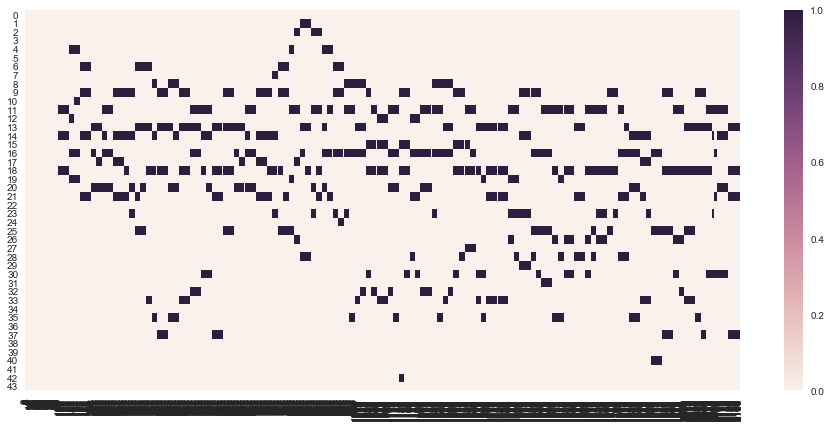

In [18]:
plt.figure(figsize=(16, 7))
sn.heatmap(X.T[lowest_note - 1: highest_note + 1, :: 30][::-1])
plt.show()

In [ ]:
# plt.figure(figsize=(16, 7))
# sn.heatmap(X_noteon.T[lowest_note - 1: highest_note + 1, :: ][::-1])
# plt.show()

Ideas:
- Two channels:
     - note on  channel (just a bit for note ons)
     - note off channel (just a bit for note offs)

Find patterns

In [ ]:
import tensorflow as tf

In [ ]:
session = tf.Session()

In [ ]:
x_in = tf.placeholder(dtype='float32', shape=[1, None, 128, 1]) # batch, height, width, channels

In [ ]:
# [filter_height, filter_width, in_channels, out_channels]
_filter = tf.Variable(initial_value=tf.random_normal(shape=(600, 128, 1, 1), mean=0.5, stddev=0.1))
_filter = tf.clip_by_value(_filter, 0, 1)

In [ ]:
conv_result = tf.nn.conv2d(x_in, _filter, strides=[1,1,1,1], padding="VALID")

In [ ]:
opt = tf.train.AdamOptimizer().minimize(-conv_result)

In [ ]:
session.run(tf.global_variables_initializer())

In [ ]:
session.run(opt, feed_dict={x_in: X[None, :, :, None]})

In [ ]:
session.run()

# This looks fishy, there are usually 4 voices in a chorale. Next loop processes all the midi

except for the break...

In [ ]:
import os

In [ ]:
train_set = []

path = 'JSB Chorales/train'
for f in os.listdir(path):
    mid = MidiFile(os.path.join(path, f))
    X = get_note_array(compute_note_positions(mid))
    plt.figure(figsize=(16, 7))
    sn.heatmap(X.T[50: 100, ::120][::-1])
    plt.show()
    train_set.append(X)
    
    break # remove me

# Get It

This code downloads the chorales and saves them as midi in a folder "JS Chorales"

In [ ]:
"""
Example of iterating Bach Chorales and getting individual voice parts
In this case, want specifically 4 voice pieces only
Also transpose to key of C (major or minor depending on piece)
Also shows how to write out all the xml as midi
"""
# Author: Kyle Kastner
# License: BSD 3-Clause
# Based on StackOverflow answer
# http://stackoverflow.com/questions/36647054/music21-getting-all-notes-with-durations
# midi writing modified from tests inside music21
from music21 import corpus, interval, pitch
import time
import numpy as np
import os


def write_midi(pitch_block, duration_block, outfile="out.mid",
               qpm_multiplier=1024, tempo_multiplier=1.0):
    # Assumes any element with
    from music21.midi import MidiTrack, MidiFile, MidiEvent, DeltaTime
    # duration, pitch, velocity

    qpm_mult = qpm_multiplier
    all_mt = []

    for i in range(pitch_block.shape[0]):
        mt = MidiTrack(1)
        t = 0
        t_last = 0
        pitch_slice = pitch_block[i, :]
        duration_slice = duration_block[i, :]
        beat_slice = list((qpm_mult * duration_slice).astype("int32"))
        pitch_slice = list(pitch_slice.astype("int32"))
        for d, p in zip(beat_slice, pitch_slice):
            if (p == -1) or (d == -1):
                # bypass
                continue
            dt = DeltaTime(mt)
            dt.time = t - t_last
            mt.events.append(dt)

            me = MidiEvent(mt)
            me.type = "NOTE_ON"
            me.channel = 1
            me.time = None
            me.pitch = p
            me.velocity = 90
            mt.events.append(me)

            # add note off / velocity zero message
            dt = DeltaTime(mt)
            dt.time = d
            # add to track events
            mt.events.append(dt)

            me = MidiEvent(mt)
            me.type = "NOTE_ON"
            me.channel = 1
            me.time = None
            me.pitch = p
            me.velocity = 0
            mt.events.append(me)
            t_last = t + d
            t += d

        # add end of track
        dt = DeltaTime(mt)
        dt.time = 0
        mt.events.append(dt)

        me = MidiEvent(mt)
        me.type = "END_OF_TRACK"
        me.channel = 1
        me.data = ''
        mt.events.append(me)
        all_mt.append(mt)

    mf = MidiFile()
    mf.ticksPerQuarterNote = int(tempo_multiplier * qpm_mult)
    for mt in all_mt:
        mf.tracks.append(mt)

    mf.open(outfile, 'wb')
    mf.write()
    mf.close()


start = time.time()
all_bach_paths = corpus.getComposer('bach')
print("Total number of Bach pieces to process from music21: %i" % len(all_bach_paths))
skipped = 0
processed = 0
n_major = 0
n_minor = 0
all_major = []
all_minor = []
for it, p_bach in enumerate(all_bach_paths):
    if "riemenschneider" in str(p_bach):
        # skip certain files we don't care about
        skipped += 1
        continue
    p = corpus.parse(p_bach)
    if len(p.parts) != 4:
        print("Skipping file %i, %s due to undesired voice count..." % (it, p_bach))
        skipped += 1
        continue
    print("Processing %i, %s ..." % (it, p_bach))

    k = p.analyze('key')
    print("Original key: %s" % k)
    i = interval.Interval(k.tonic, pitch.Pitch('C'))
    p = p.transpose(i)
    k = p.analyze('key')
    print("Transposed key: %s" % k)
    if 'major' in k.name:
        n_major += 1
    elif 'minor' in k.name:
        n_minor += 1
    else:
        raise ValueError('Unknown key %s' % k.name)

    try:
        parts = []
        parts_times = []
        for i, pi in enumerate(p.parts):
            part = []
            part_time = []
            for n in pi.stream().flat.notesAndRests:
                if n.isRest:
                    part.append(0)
                else:
                    part.append(n.midi)
                part_time.append(n.duration.quarterLength)
            parts.append(part)
            parts_times.append(part_time)

        # Create a "block" of events and times
        cumulative_times = map(lambda x: list(np.cumsum(x)), parts_times)
        event_points = sorted(list(set(sum(cumulative_times, []))))
        maxlen = max(map(len, cumulative_times))
        # -1 marks invalid / unused
        part_block = np.zeros((len(p.parts), maxlen)).astype("int32") - 1
        ctime_block = np.zeros((len(p.parts), maxlen)).astype("float32") - 1
        time_block = np.zeros((len(p.parts), maxlen)).astype("float32") - 1
        # create numpy array for easier indexing
        for i in range(len(parts)):
            part_block[i, :len(parts[i])] = parts[i]
            ctime_block[i, :len(cumulative_times[i])] = cumulative_times[i]
            time_block[i, :len(parts_times[i])] = parts_times[i]

        event_block = np.zeros((len(p.parts), len(event_points))) - 1
        etime_block = np.zeros((len(p.parts), len(event_points))) - 1
        for i, e in enumerate(event_points):
            idx = zip(*np.where(ctime_block == e))
            for ix in idx:
                event_block[ix[0], i] = part_block[ix[0], ix[1]]
                etime_block[ix[0], i] = time_block[ix[0], ix[1]]

        bach_name = "_".join(p_bach.split(os.sep)[-1].split(".")[:-1])
        midi_outfile = bach_name + ".mid"
        write_midi(event_block, etime_block,
                   outfile="midifiles/" + midi_outfile,
                   tempo_multiplier=1.0)
        # Grouping
        processed += 1
    except AttributeError:
        skipped += 1
        # Edge case for Chord error? Should be flat container but some piece is different
        continue

stop = time.time()
print("Total skipped count: %i" % skipped)
print("Total processed count: %i" % processed)
print("Total major: %i" % n_major)
print("Total minor: %i" % n_minor)
print("Total processing time (seconds): %f" % (stop - start))